In [1]:
from pathlib import Path

import submitit
import torch
from diffdrr.drr import DRR
from diffdrr.metrics import MultiscaleNormalizedCrossCorrelation2d
from pytorch_transformers.optimization import WarmupCosineSchedule
from timm.utils.agc import adaptive_clip_grad as adaptive_clip_grad_
from tqdm import tqdm
import ipdb
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

from PIL import Image
import torchvision.transforms as T


In [2]:
import os
import sys

# Function to find the root directory of the project
def find_project_root(current_path, marker_file):
    while current_path != os.path.dirname(current_path):
        if marker_file in os.listdir(current_path):
            return current_path
        current_path = os.path.dirname(current_path)
    return None

# Get the current working directory
cwd = os.getcwd()

marker_file = '.git'

# Find the root directory
project_root = find_project_root(cwd, marker_file)

sys.path.append(project_root)

from diffpose.calibration import RigidTransform, perspective_projection, convert
from diffpose.kneefit import KneeFitDataset, Transforms, get_random_offset, get_volume_data
from diffpose.metrics import DoubleGeodesic, GeodesicSE3
from diffpose.registration import PoseRegressor


In [3]:
device = torch.device("cuda")
torch.cuda.is_available()

True

In [4]:
torch.cuda.empty_cache()

In [5]:
iso = RigidTransform(
            torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]),
            torch.tensor([100, 100.0, 175]),
        )

offset = RigidTransform(
            torch.tensor([[1.0, 0.0, 0.0], [0.0, 2.0, 0.0], [0.0, 0.0, 3.0]]),
            torch.tensor([1.0,2,3]),
        )

c = iso.compose(offset)
print(c.get_rotation())
print(c.get_translation())


tensor([[[1., 0., 0.],
         [0., 2., 0.],
         [0., 0., 3.]]])
tensor([[101., 202., 528.]])


In [6]:
offset = RigidTransform(
            torch.tensor([-torch.pi/2, 0.0, 0.0]),
            torch.tensor([1.0,2,3]), "euler_angles", "XYZ"
        )
print(offset.get_rotation())
print(offset.get_translation())

tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -4.3711e-08,  1.0000e+00],
         [ 0.0000e+00, -1.0000e+00, -4.3711e-08]]])
tensor([[1., 2., 3.]])


In [10]:
from diffdrr.utils import Transform3d

iso = Transform3d(matrix = torch.tensor([[1.0, 0.0, 0.0, 100], 
                                        [0.0, 1.0, 0.0, 100],
                                        [0.0, 0.0, 1.0, 175],
                                          [0 , 0, 0, 1]]))

# Scale each axis by a different amount, then translate, then scale
offset = Transform3d(matrix = torch.tensor([[1.0, 0.0, 0.0, 1], 
                                        [0.0, 2.0, 0.0, 2], 
                                        [0.0, 0.0, 3.0, 3], 
                                        [0 , 0, 0, 1]]))


t3 = offset.compose(iso)

print(t3.get_matrix())

tensor([[[  1.,   0.,   0., 101.],
         [  0.,   2.,   0., 202.],
         [  0.,   0.,   3., 528.],
         [  0.,   0.,   0.,   1.]]])


In [14]:
def load(id_number, height, device, ct_path):
    volume, affine = get_volume_data(ct_path)
    spacing = np.array([0.390625, 0.390625, 0.800018])
    # isocenter_rot = torch.tensor([[-torch.pi / 2 ,-torch.pi / 2, -torch.pi / 2]], dtype=torch.float32)
    isocenter_rot = torch.tensor([[0, 0, 0]], dtype=torch.float32)

    isocenter_xyz = torch.tensor(volume.shape) * spacing / 2
    # shift = torch.tensor([-100,-100,0], dtype=torch.float32)
    isocenter_xyz += torch.tensor([+980/2, 0, 0], dtype=torch.float32)
    # isocenter_xyz = torch.tensor([-972.0 / 2, 50, 50], dtype=torch.float32)

    isocenter_xyz = isocenter_xyz 
    isocenter_xyz = isocenter_xyz.unsqueeze(0)
    isocenter_pose = RigidTransform(
        isocenter_rot, isocenter_xyz, "euler_angles", "XYZ"
    )
    isocenter_pose = isocenter_pose.to(device)

    focal_len = 972.2564

    # Take the height of xray sample and divide by image dimensions required by ResNet
    subsample = 1000 / height
    # delx to be retreived from combined csv file
    # delx is different for different samples, below hard-coded for SUB2
    delx = 0.2876 * subsample
    x0 = 5.7096
    y0 = 5.8591
    drr =     DRR(
        volume,
        spacing,
        focal_len,
        height,
        delx,
        x0=x0,
        y0=y0,
        reverse_x_axis=False,
        bone_attenuation_multiplier=2.0
    ).to(device)
    transforms = Transforms(height)

    return isocenter_pose, transforms, drr


In [15]:
def train(
    id_number,
    model,
    optimizer,
    scheduler,
    drr,
    transforms,
    isocenter_pose,
    device,
    batch_size,
    n_epochs,
    n_batches_per_epoch,
    model_params,
):
    metric = MultiscaleNormalizedCrossCorrelation2d(eps=1e-4)
    geodesic = GeodesicSE3()
    double = DoubleGeodesic(drr.detector.sdr)
    contrast_distribution = torch.distributions.Uniform(1.0, 10.0)

    best_loss = torch.inf

    model.train()
    #  visualization part
    offset = get_random_offset(batch_size, device)
    pose = isocenter_pose.compose(offset)

    # visualize(drr=drr, pose=pose,device=device)
    for epoch in range(n_epochs + 1):
        losses = []
        for _ in (itr := tqdm(range(n_batches_per_epoch), leave=False)):
            # bone_attenuation is chosen randomly from a uniform distribution
            contrast = contrast_distribution.sample().item()
            # generate random pose using normal distribution
            offset = get_random_offset(batch_size, device)
            pose = isocenter_pose.compose(offset)
            img = drr(None, None, None, pose=pose, bone_attenuation_multiplier=contrast)
            img = transforms(img)
            
            img = img.float()

            pred_offset = model(img)
            pred_pose = isocenter_pose.compose(pred_offset)
            pred_img = drr(None, None, None, pose=pred_pose)
            pred_img = transforms(pred_img)
            pred_img = pred_img.float()

            ncc = metric(pred_img, img)
            log_geodesic = geodesic(pred_pose, pose)
            geodesic_rot, geodesic_xyz, double_geodesic = double(pred_pose, pose)
            loss = 1 - ncc + 1e-2 * (log_geodesic + double_geodesic)
            if loss.isnan().any():
                print("Aaaaaaand we've crashed...")
                print(ncc)
                print(log_geodesic)
                print(geodesic_rot)
                print(geodesic_xyz)
                print(double_geodesic)
                print(pose.get_matrix())
                print(pred_pose.get_matrix())
                torch.save(
                    {
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "height": drr.detector.height,
                        "epoch": epoch,
                        "batch_size": batch_size,
                        "n_epochs": n_epochs,
                        "n_batches_per_epoch": n_batches_per_epoch,
                        "pose": pose.get_matrix().cpu(),
                        "pred_pose": pred_pose.get_matrix().cpu(),
                        "img": img.cpu(),
                        "pred_img": pred_img.cpu()
                        **model_params,
                    },
                    f"checkpoints/specimen_{id_number:02d}_crashed.ckpt",
                )
                raise RuntimeError("NaN loss")

            optimizer.zero_grad()
            loss.mean().backward()
            adaptive_clip_grad_(model.parameters())
            optimizer.step()
            scheduler.step()

            losses.append(loss.mean().item())

            # Update progress bar
            itr.set_description(f"Epoch [{epoch}/{n_epochs}]")
            itr.set_postfix(
                geodesic_rot=geodesic_rot.mean().item(),
                geodesic_xyz=geodesic_xyz.mean().item(),
                geodesic_dou=double_geodesic.mean().item(),
                geodesic_se3=log_geodesic.mean().item(),
                loss=loss.mean().item(),
                ncc=ncc.mean().item(),
            )

            prev_pose = pose
            prev_pred_pose = pred_pose

        losses = torch.tensor(losses)
        tqdm.write(f"Epoch {epoch + 1:04d} | Loss {losses.mean().item():.4f}")
        if losses.mean() < best_loss and not losses.isnan().any():
            best_loss = losses.mean().item()
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "height": drr.detector.height,
                    "epoch": epoch,
                    "loss": losses.mean().item(),
                    "batch_size": batch_size,
                    "n_epochs": n_epochs,
                    "n_batches_per_epoch": n_batches_per_epoch,
                    **model_params,
                },
                f"checkpoints/specimen_{id_number:02d}_best.ckpt",
            )

        if epoch % 50 == 0:
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "height": drr.detector.height,
                    "epoch": epoch,
                    "loss": losses.mean().item(),
                    "batch_size": batch_size,
                    "n_epochs": n_epochs,
                    "n_batches_per_epoch": n_batches_per_epoch,
                    **model_params,
                },
                f"checkpoints/specimen_{id_number:02d}_epoch{epoch:03d}.ckpt",
            )



In [16]:
def main(
    id_number,
    ct_path,
    height=256,
    restart=None,
    skip_training = False,
    model_name="resnet18",
    parameterization="se3_log_map",
    convention=None,
    lr=1e-3,
    batch_size=3,
    n_epochs=5,
    n_batches_per_epoch=10,
    
):
    id_number = int(id_number)

    
    isocenter_pose, transforms, drr = load(id_number, height, device, ct_path=ct_path)

    model_params = {
        "model_name": model_name,
        "parameterization": parameterization,
        "convention": convention,
        "norm_layer": "groupnorm",
    }
    model = PoseRegressor(**model_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if restart is not None:
        print("Loading from checkpoint = " + str(restart))
        ckpt = torch.load(restart)
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    model = model.to(device)

    scheduler = WarmupCosineSchedule(
        optimizer,
        5 * n_batches_per_epoch,
        n_epochs * n_batches_per_epoch - 5 * n_batches_per_epoch,
    )

    Path("checkpoints").mkdir(exist_ok=True)
    if not skip_training:
        train(
            id_number,
            model,
            optimizer,
            scheduler,
            drr,
            transforms,
            isocenter_pose,
            device,
            batch_size,
            n_epochs,
            n_batches_per_epoch,
            model_params,
        )

    return model, drr, isocenter_pose




In [17]:

# if __name__ == "__main__":
    # id_numbers = [1, 2, 3, 4, 5, 6]
    # Path("checkpoints").mkdir(exist_ok=True)

    # executor = submitit.AutoExecutor(folder="logs")
    # executor.update_parameters(
    #     name="deepfluoro",
    #     gpus_per_node=1,
    #     mem_gb=43.5,
    #     slurm_array_parallelism=len(id_numbers),
    #     slurm_partition="A6000",
    #     slurm_exclude="sumac,fennel",
    #     timeout_min=10_000,
    # )
    # jobs = executor.map_array(main, id_numbers)

    # main(1, )

### tibia 1

In [18]:
ct_path = project_root + r"\data\example\SUBN_02_Tibia_RE_Volume.nii"
# ct_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\example\SUBN_02_Tibia_RE_Volume.nii"
final_model, patient_drr, iso_pose = main(1, ct_path=ct_path, skip_training=True)

# import nibabel as nib
# img = nib.load(ct_path).get_fdata()
# img.shape
# from skimage.transform import rotate


# plt.style.use('default')
# fig, axes = plt.subplots(4,4, figsize=(12,12))
# for i, ax in enumerate(axes.reshape(-1)):
#     img_rot = rotate(img[:,:,1+i], 0)
#     ax.imshow(img_rot)
# plt.show()

In [19]:
# from skimage.transform import rotate

# x_slices = img.shape[0] // 4
# y_slices = img.shape[1] // 4
# z_slices = img.shape[2] // 4

# plt.style.use('default')
# fig, axes = plt.subplots(3,4, figsize=(12,12))
# for i, ax in enumerate(axes.reshape(-1)):
#     if i // 4 == 0:
#         img_rot = rotate(img[(i%4*x_slices),:,:], 0)
#         ax.imshow(img_rot)
#         ax.set_title(f"x={(i%4*x_slices)}")
#     if i // 4 == 1:
#         img_rot = rotate(img[:,(i%4*y_slices),:], 0)
#         ax.imshow(img_rot)
#         ax.set_title(f"y={(i%4*y_slices)}")
#     if i // 4 == 2:
#         img_rot = rotate(img[:,:,(i%4*z_slices)], 0)
#         ax.imshow(img_rot)
#         ax.set_title(f"z={(i%4*z_slices)}")
# plt.show()

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming img is your XYZ image data with shape (height, width, 3)
# # For the purpose of this example, we'll create a mock XYZ image
# height, width = 256, 256

# # Channels names
# channels = ('X', 'Y', 'Z')
# colors = ('r', 'g', 'b')

# # Create a figure to hold the subplots
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# # Loop through each channel
# for i, (channel, color) in enumerate(zip(channels, colors)):
#     # Extract the i-th channel
#     channel_data = img[:, :, i]
    
#     # Plot the histogram
#     ax = axes[i]
#     ax.hist(channel_data.ravel(), bins=256, color=color, alpha=0.75)
#     ax.set_title(f'{channel} Channel Histogram')
#     ax.set_xlabel('Value')
#     ax.set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()

In [21]:
def visualize( drr, pose , gt_xray, device):
    transform = T.ToPILImage()
    pred_xray = drr(None, None, None, pose=pose.to(device))

    # print("drr xray shape", drr_xray.detach().cpu().numpy().shape)
    background = (gt_xray / 256).astype(np.uint8)
    background = background.reshape(256, 256, 1)
    overlay = transform(pred_xray.squeeze().detach().cpu().numpy())
    background = transform(background)

    # background = background.convert("RGB")
    # overlay = overlay.convert("RGB")
    # print('size', background.size)
    # print('size', overlay.size)
    new_img = Image.blend(background, overlay, 0.5)

    # print(pose.get_translation())
    # print(pose.get_rotation())
    # print("unique values in drr", torch.unique(drr_xray))
    plt.figure(constrained_layout=False)
    plt.subplot(121)
    plt.title("DRR")
    # drr_xray = pred_xray[0,:,:,:]
    plt.imshow(new_img, cmap="gray")


    # plt.imshow(drr_xray.squeeze().detach().cpu().numpy(), cmap="gray")
    # plt.show()

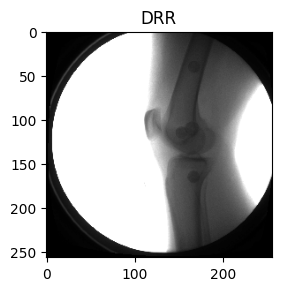

In [22]:
def process_image():
    test_xray_path = project_root + r"\data\example\C_SUBN_02_dkb_01_001-256_resize.tif"
    # test_xray_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\example\C_SUBN_02_dkb_01_001.tif"
    gt_t = [30.71312059, 14.60485098, -886.6538903]
    gt_r = [
        [0.069805471, -0.909693937, 0.409370416],
        [-0.084526552, 0.403501781, 0.911066175],
        [-0.993973067, -0.098200073, -0.04872666]
    ]
    gt_t = [886,14,30]
    gt_r = [0,0,0]
    # gt_r = [-116.39, 83.71, -50.45] # Converted gt_r into euler angles

    gt_t_tensor = torch.tensor(gt_t, dtype=torch.float32, device=device)
    gt_r_tensor = torch.tensor(gt_r, dtype=torch.float32, device=device)
    gt_r_tensor = gt_r_tensor.unsqueeze(0)
    gt_t_tensor = gt_t_tensor.unsqueeze(0)
    # Read the image
    xray_img = Image.open(test_xray_path)
    xray_img = tiff.imread(test_xray_path)
    
    # xray_tensor = torch.tensor(xray_img, dtype=torch.float32, device=device)
    # plt.imshow(xray_tensor.cpu().numpy())
    # xray_tensor = xray_tensor.unsqueeze(0).unsqueeze(0)

    # print(xray_tensor.shape)

    # pred_offset_test = final_model(xray_tensor)
    # pred_pose_test = iso_pose.compose(pred_offset_test)
    # pred_r_test = pred_pose_test.get_rotation()
    # pred_t_test = pred_pose_test.get_translation()
    # print(pred_r_test)
    # print(pred_t_test)
    # predicted_pose_test = RigidTransform(pred_r_test, pred_t_test,"matrix", "XYZ")
    gt_pose = RigidTransform(gt_r_tensor, gt_t_tensor, parameterization="matrix", convention="XYZ")

    visualize(drr=patient_drr, pose= gt_pose, gt_xray=xray_img, device=device)

    
    torch.cuda.empty_cache()

process_image()

In [23]:

test_xray_path = project_root + r"\data\example\C_SUBN_02_dkb_01_022-256_resize.tif"

im = Image.open(test_xray_path)
# im_ten = pil_to_tensor(im)
# im = im.resize((256, 256))
# im.save(project_root+r"\data\example\C_SUBN_02_dkb_01_022-256_resize.png")

In [24]:
def vis_drr(drr, pose):
    pred_xray = drr(None, None, None, pose=pose.to(device))

    #| label: bone_attenuation_multiplier=1.0
#| code-fold: true
#| eval: false
    plt.figure(constrained_layout=True)
    plt.subplot(121)
    plt.title("DRR")
    plt.imshow(pred_xray.squeeze().cpu().numpy(), cmap="gray")

    plt.show()

### tibia 1


gt_r tensor([-1.5742, -0.0896,  1.6170], device='cuda:0')
torch.Size([1, 1, 256, 256])
tensor([[[ 0.5084,  0.0757,  0.8578],
         [-0.3064,  0.9468,  0.0980],
         [-0.8047, -0.3127,  0.5046]]], device='cuda:0',
       grad_fn=<TransposeBackward0>)
tensor([[ 457.8572,  -68.6774, -417.4135]], device='cuda:0',
       grad_fn=<SliceBackward0>)
rotation tensor([[-1.6604,  0.0034,  0.0465]], device='cuda:0')
translation tensor([[1470.9868,  175.8123, -117.1864]], device='cuda:0')


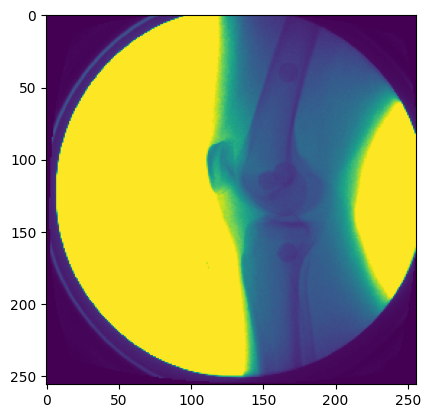

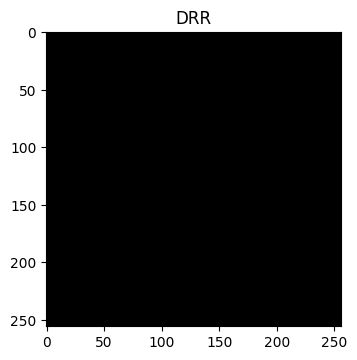

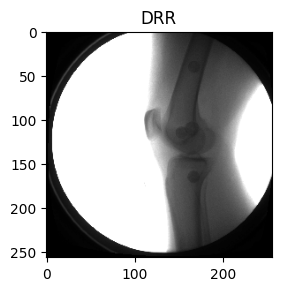

In [53]:
from diffdrr.utils import _convert_from_rotation_matrix

def process_image():
    test_xray_path = project_root + r"\data\example\C_SUBN_02_dkb_01_001-256_resize.tif"
    # test_xray_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\example\C_SUBN_02_dkb_01_001.tif"
    gt_t = [25.13823484, 14.69981871, -885.6809745]
    gt_r = [
        [-0.04602752,	-0.994925254,	-0.089471819],
        [-0.00756964,	-0.089216793,	0.995983466],
        [-0.998911492,	0.046519919,	-0.003424799]
    ]

    # gt_t = [0,80,80]
    # gt_r = [-torch.pi/2,0,0]
    # gt_r = rotation_matrix_to_euler_angles(np.array(gt_r))
    # gt_t = [886,14,25]
    # gt_r = [0,0,0]

    gt_t_tensor = torch.tensor(gt_t, dtype=torch.float32, device=device)
    gt_r_tensor = torch.tensor(gt_r, dtype=torch.float32, device=device)
    gt_r_tensor = _convert_from_rotation_matrix(gt_r_tensor, parameterization="euler_angles", convention="XYZ")

    print('gt_r', gt_r_tensor)

    gt_r_tensor = gt_r_tensor.unsqueeze(0)
    gt_t_tensor = gt_t_tensor.unsqueeze(0)
    # Read the image
    xray_img = tiff.imread(test_xray_path)

    xray_tensor = torch.tensor(xray_img, dtype=torch.float32, device=device)
    plt.imshow(xray_tensor.cpu().numpy())
    xray_tensor = xray_tensor.unsqueeze(0).unsqueeze(0)

    print(xray_tensor.shape)

    pred_offset_test = final_model(xray_tensor)
    pred_pose_test = iso_pose.compose(pred_offset_test)
    pred_r_test = pred_pose_test.get_rotation()
    pred_t_test = pred_pose_test.get_translation()
    print(pred_r_test)
    print(pred_t_test)
    predicted_pose_test = RigidTransform(pred_r_test, pred_t_test,"matrix", "XYZ")

    flip_xz = RigidTransform(
            torch.tensor([[0.0, 0.0, -1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]),
            torch.zeros(3), device=device
        )

    gt_pose = RigidTransform(gt_r_tensor, gt_t_tensor, parameterization="euler_angles", convention="XYZ")
    gt_pose = iso_pose.compose(gt_pose.compose(flip_xz))



    print('rotation', gt_pose.get_rotation(parameterization="euler_angles", convention="XYZ"))
    print('translation', gt_pose.get_translation())

    vis_drr(patient_drr, gt_pose)
    visualize(drr=patient_drr, pose= gt_pose, gt_xray=xray_img, device=device)
    
    del gt_t_tensor, gt_r_tensor, xray_tensor, pred_offset_test, pred_pose_test, pred_r_test, pred_t_test
    torch.cuda.empty_cache()

process_image()

### tibia 2

gt_r tensor([[-0.2209, -0.9442, -0.2444],
        [-0.0278, -0.2443,  0.9693],
        [-0.9749,  0.2209,  0.0277]], device='cuda:0')
torch.Size([1, 1, 256, 256])
tensor([[[ 0.8776,  0.4691,  0.0990],
         [-0.4359,  0.8666, -0.2428],
         [-0.1997,  0.1700,  0.9650]]], device='cuda:0',
       grad_fn=<TransposeBackward0>)
tensor([[-873.7250,  360.1278,  283.3481]], device='cuda:0',
       grad_fn=<SliceBackward0>)
rotation tensor([[  -1.6337,   12.7632, -104.5098]], device='cuda:0')
translation tensor([[867.0717,   0.9435, -42.7035]], device='cuda:0')
size (256, 256)
size (256, 256)
tensor([[867.0717,   0.9435, -42.7035]], device='cuda:0')
tensor([[[ 0.9749, -0.2209, -0.0277],
         [-0.0278, -0.2443,  0.9693],
         [-0.2209, -0.9442, -0.2444]]], device='cuda:0')
unique values in drr tensor([0.0000e+00, 8.0404e-03, 1.2430e-02,  ..., 1.6341e+01, 1.6443e+01,
        1.6618e+01], device='cuda:0', dtype=torch.float64)


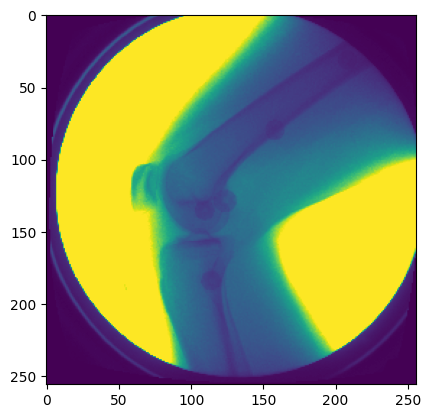

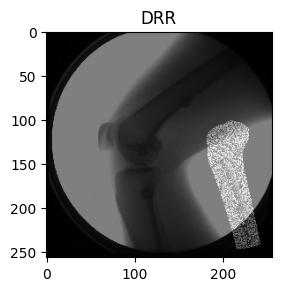

In [16]:
from diffdrr.utils import _convert_from_rotation_matrix

def process_image():
    test_xray_path = project_root + r"\data\example\C_SUBN_02_dkb_01_022-256_resize.tif"
    # test_xray_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\example\C_SUBN_02_dkb_01_001.tif"
    shift = torch.tensor([-5.7, 115.7, -105.7], device=device)
    # shift = torch.tensor([200, 110, 0], device=device)
    gt_t = [-42.70353616, 0.943520498, -867.0716624]
    ### gt / spacing = mm and pixel/mm === pixel (camera coordinates)
    # gt_t = [a / b for a, b in zip(gt_t, [0.8, 0.39, -0.39])]
    # shift
    # gt_t = [-116.402, -196.095, -947.326]

    gt_r = [
        [-0.220921972,	-0.944184143,	-0.244355859],
        [-0.027805827,	-0.244346993,	0.969289112],
        [-0.974895029,	0.220931779,	0.027727799]
    ]

    # gt_r = np.zeros((3,3), dtype=np.float32)
    # gt_t = np.zeros(3, dtype=np.float32)

    # gt_t = [0,80,80]
    # gt_r = [-torch.pi/2,0,0]
    # gt_r = rotation_matrix_to_euler_angles(np.array(gt_r))
    gt_t_tensor = torch.tensor(gt_t, dtype=torch.float32, device=device)
    # gt_t_tensor += shift
    gt_r_tensor = torch.tensor(gt_r, dtype=torch.float32, device=device)
    # gt_r_tensor = _convert_from_rotation_matrix(gt_r_tensor, parameterization="euler_angles", convention="XYZ")

    print('gt_r', gt_r_tensor)

    gt_r_tensor = gt_r_tensor.unsqueeze(0)
    gt_t_tensor = gt_t_tensor.unsqueeze(0)
    # Read the image
    xray_img = tiff.imread(test_xray_path)

    xray_tensor = torch.tensor(xray_img, dtype=torch.float32, device=device)
    plt.imshow(xray_tensor.cpu().numpy())
    xray_tensor = xray_tensor.unsqueeze(0).unsqueeze(0)

    print(xray_tensor.shape)

    pred_offset_test = final_model(xray_tensor)
    pred_pose_test = iso_pose.compose(pred_offset_test)
    pred_r_test = pred_pose_test.get_rotation()
    pred_t_test = pred_pose_test.get_translation()
    print(pred_r_test)
    print(pred_t_test)
    predicted_pose_test = RigidTransform(pred_r_test, pred_t_test,"matrix", "XYZ")

    flip_xz = RigidTransform(
            torch.tensor([[0.0, 0.0, -1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]),
            torch.zeros(3), device=device
        )

    # gt_pose = RigidTransform(gt_r_tensor, gt_t_tensor, parameterization="euler_angles", convention="XYZ")
    gt_pose = RigidTransform(gt_r_tensor, gt_t_tensor)
    gt_pose = gt_pose.compose(flip_xz)



    print('rotation', gt_pose.get_rotation(parameterization="euler_angles", convention="ZYX")*180/torch.pi)
    print('translation', gt_pose.get_translation())


    visualize(drr=patient_drr, pose= gt_pose, gt_xray=xray_img, device=device)

    del gt_t_tensor, gt_r_tensor, xray_tensor, pred_offset_test, pred_pose_test, pred_r_test, pred_t_test
    torch.cuda.empty_cache()

process_image()

In [289]:
test_r = np.array([
        [-0.220921972,	-0.944184143,	-0.244355859, 0],
        [-0.027805827,	-0.244346993,	0.969289112, 0],
        [-0.974895029,	0.220931779,	0.027727799,0 ],
        [0,0,0,1]
    ])

i = np.array([  [1,0,0, 1],
                [0,1,0, 2],
                [0,0,1, 3],
                [0,0,0, 1]])
j = np.array([  [1,0,0, 4],
                [0,1,0, 5],
                [0,0,1, 6],
                [0,0,0, 1]])

b = np.matmul( i, j)
print(b)
b = np.matmul(  j, i)
print(b)


[[1 0 0 5]
 [0 1 0 7]
 [0 0 1 9]
 [0 0 0 1]]
[[1 0 0 5]
 [0 1 0 7]
 [0 0 1 9]
 [0 0 0 1]]


In [294]:
test_r = np.array([
        [-0.220921972,	-0.944184143,	-0.244355859, 1],
        [-0.027805827,	-0.244346993,	0.969289112, 2],
        [-0.974895029,	0.220931779,	0.027727799,3 ],
        [0,0,0,1]
    ])
R = test_r[:3,:3]
t = test_r[:3,3]
print(np.matmul(np.linalg.inv(R),t))
test_r_inv = np.linalg.inv(test_r)
test_r_inv

[-3.20121871 -0.77008279  1.77740576]


array([[-0.22092197, -0.02780583, -0.97489503,  3.20121871],
       [-0.94418414, -0.24434699,  0.22093178,  0.77008279],
       [-0.24435586,  0.96928911,  0.0277278 , -1.77740576],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [285]:
from scipy.spatial.transform import Rotation   

### first transform the matrix to euler angles
r =  Rotation.from_matrix(test_r_inv)
angles = r.as_euler("zyx",degrees=True)

#### Modify the angles
print(angles)


[172.82632246 -77.13439307 -82.84655862]


gt with zyx convention 
[103.16925712 -14.14377023 -88.36142518]

gt_inv with xyz convention
[  88.36142523   14.14377022 -103.16925706]


op rot after flip xz
[[-104.1493,   -1.5889,   12.7688]]

rotation tensor([[  -1.6337,   12.7632, -104.5098]], device='cuda:0')


###  plotting to understand

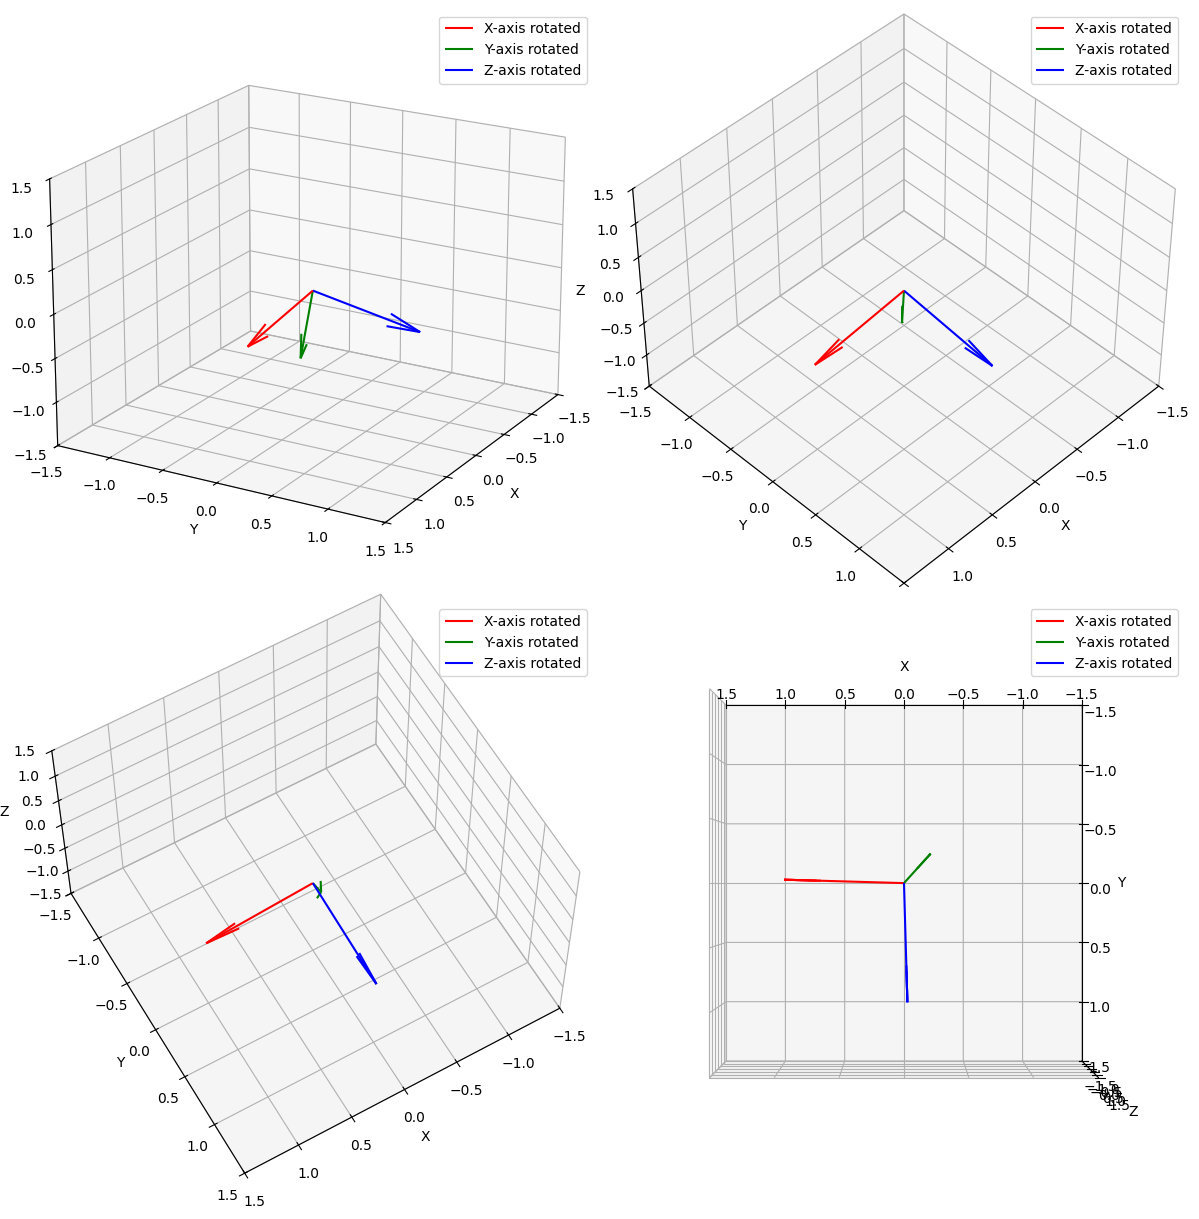

In [235]:
# plot my rotation


def plot_vector(ax, vec, color, label):
    """
    Plot a 3D vector starting from the origin.
    """
    ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color=color, label=label)

# Create the figure and the 3D axis
fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(111, projection='3d')

# Original basis vectors
x = np.array([1, 0, 0])
y = np.array([0, 1, 0])
z = np.array([0, 0, 1])

# Define different views
views = [(20, 30), (45, 45), (60, 60), (90, 90)]
axes = [fig.add_subplot(2, 2, i + 1, projection='3d') for i in range(4)]

# Plot original basis vectors
# plot_vector(ax, x, 'r', 'X-axis')
# plot_vector(ax, y, 'g', 'Y-axis')
# plot_vector(ax, z, 'b', 'Z-axis')

# Define the axis of rotation and angle (in radians)
axis = np.array([1, 1, 0])
theta = np.pi / 4  # 45 degrees

R = np.array([[ 0.9749, -0.2209, -0.0277],
         [-0.0278, -0.2443,  0.9693],
         [-0.2209, -0.9442, -0.2444]])

# axis = np.array([[-104.1493,   -1.5889,   12.7688]])
# R = rotation_matrix(axis, theta)

# Rotate the basis vectors
x_rot = R @ x
y_rot = R @ y
z_rot = R @ z

for ax, (elev, azim) in zip(axes, views):

    # Plot rotated basis vectors
    plot_vector(ax, x_rot, 'r', 'X-axis rotated')
    plot_vector(ax, y_rot, 'g', 'Y-axis rotated')
    plot_vector(ax, z_rot, 'b', 'Z-axis rotated')

    # Setting the plot
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([-1.5, 1.5])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=elev, azim=azim)  # Set the view angle
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))  # Normalize the axis
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    return np.array([[a*a + b*b - c*c - d*d, 2*(b*c - a*d), 2*(b*d + a*c)],
                     [2*(b*c + a*d), a*a + c*c - b*b - d*d, 2*(c*d - a*b)],
                     [2*(b*d - a*c), 2*(c*d + a*b), a*a + d*d - b*b - c*c]])

def translation_matrix(tx, ty, tz):
    """
    Return the translation matrix for the given translation vector.
    """
    return np.array([[1, 0, 0, tx],
                     [0, 1, 0, ty],
                     [0, 0, 1, tz],
                     [0, 0, 0, 1]])

def apply_transformation(points, transformation_matrix):
    """
    Apply a transformation matrix to a set of points in homogeneous coordinates.
    """
    # Convert points to homogeneous coordinates
    points_h = np.hstack((points, np.ones((points.shape[0], 1))))
    # Apply the transformation
    transformed_points_h = points_h @ transformation_matrix.T
    # Convert back to Cartesian coordinates
    return transformed_points_h[:, :3]

# Define points (e.g., basis vectors)
points = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

# Define rotation (45 degrees around [1, 1, 0])
axis = [1, 1, 0]
theta = np.pi / 4
R = rotation_matrix(axis, theta)

# Define translation (e.g., translate by [1, 2, 3])
T = translation_matrix(1, 2, 3)

# Combine transformations (rotate then translate)
M = T @ np.vstack((R, [0, 0, 0, 1]))

# Apply combined transformation to points
transformed_points = apply_transformation(points, M)

# Plot original and transformed points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='r', label='Original')
ax.scatter(transformed_points[:, 0], transformed_points[:, 1], transformed_points[:, 2], color='b', label='Transformed')

# Set plot limits
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 4])
ax.set_zlim([-2, 4])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

In [ ]:
def visualize( drr, pose , gt_xray, device):
    transform = T.ToPILImage()
    pred_xray = drr(None, None, None, pose=pose.to(device))
    drr_xray = pred_xray[0,:,:,:]
    print('type of drr xray', type(drr_xray))
    print('type of gt_ xray', type(gt_xray))

    print("drr xray shape", drr_xray.shape)

    # print('drr_xray.shape', drr_xray.shape)

    # background = Image.fromarray(gt_xray.astype(np.uint16))
    background = gt_xray.reshape(256, 256, 1)
    print("gt_xray shape", gt_xray.shape)


    overlay = transform(drr_xray.squeeze().detach().cpu().numpy())
    background = transform(background)
    # overlay.save("faces.png", "PNG")
    # overlay = Image.open("faces.png")
    print('type',type(background))
    print('type', type(overlay))
    print('size', background.size)
    print('size', overlay.size)

    background.show()
    overlay.show()



    background = background.convert("RGB")
    overlay = overlay.convert("RGB")
    print('size', background.size)
    print('size', overlay.size)
    new_img = Image.blend(background, overlay, 0.5)

    # print(background[0, 0])
    # new_img.save("new.png","PNG")
    # new_img.show()
    # background.show()
    # overlay.show()
    # print("PRINTING SHIT HERE")
    print(gt_xray.shape)
    print(pose.get_translation())
    print(pose.get_rotation())
    plt.figure(constrained_layout=False)
    plt.subplot(121)
    plt.title("DRR")
    drr_xray = pred_xray[0,:,:,:]

    plt.imshow(drr_xray.squeeze().detach().cpu().numpy(), cmap="gray")
    plt.show()

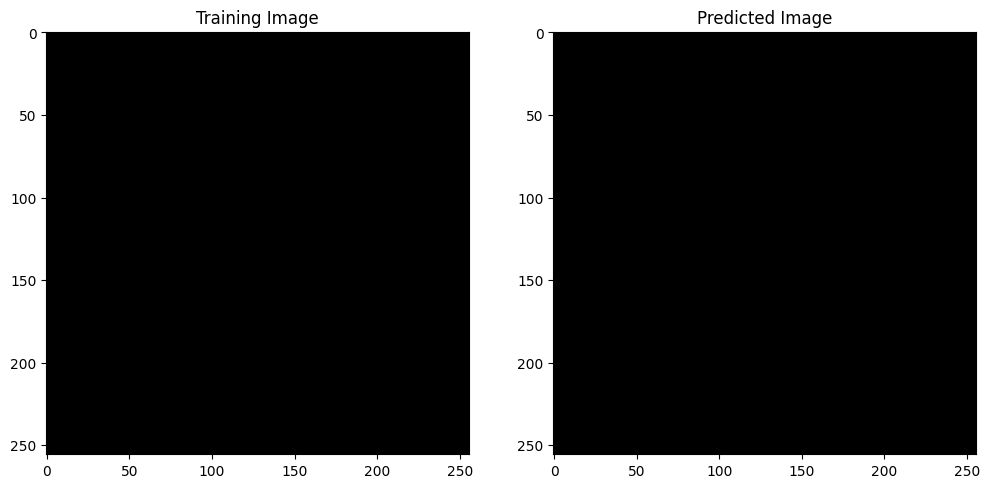

In [140]:
# TRAIN EXAMPLE
transforms = Transforms(256)
log_R_vee = torch.tensor([[0,0,0]], dtype=torch.float32).to(device)
log_t_vee = torch.tensor([[0, 0, 0]], dtype=torch.float32).to(device)


offset =  convert(
    [log_R_vee, log_t_vee],
    "se3_log_map",
    "se3_exp_map",
)

pose = iso_pose.compose(offset)
contrast_distribution = torch.distributions.Uniform(1,1.1 )
train_img = patient_drr(None, None, None, pose=pose, bone_attenuation_multiplier=contrast_distribution.sample().item())
train_img = transforms(train_img)

train_img = train_img.float()
pred_offset_train = final_model(train_img)
pred_pose_train = iso_pose.compose(pred_offset_train)
pred_img = patient_drr(None, None, None, pose=pred_pose_train)
pred_img = transforms(pred_img)
pred_img = pred_img.float()

train_img_np = train_img.detach().cpu().numpy().squeeze(0).squeeze(0)
pred_img_np = pred_img.detach().cpu().numpy().squeeze(0).squeeze(0)
# Create subplots
plt.figure(figsize=(12, 6))

# Plot the training image
plt.subplot(1, 2, 1)
plt.imshow(train_img_np, cmap='gray')
plt.title("Training Image")

# Plot the predicted image
plt.subplot(1, 2, 2)
plt.imshow(pred_img_np, cmap='gray')
plt.title("Predicted Image")

# Display the plots
plt.show()


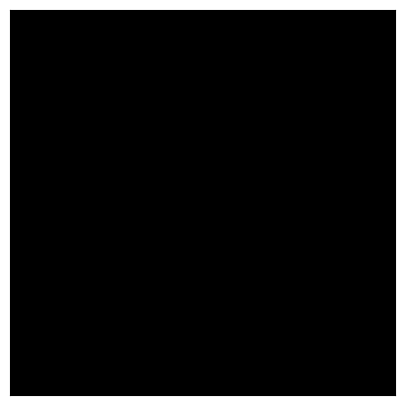

In [690]:
from diffdrr.visualization import plot_drr

rotations = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[30, 14, -200]], device=device)

img = patient_drr(rotations, translations, parameterization="euler_angles", convention="ZXY")

plot_drr(img, ticks=False)
plt.show()

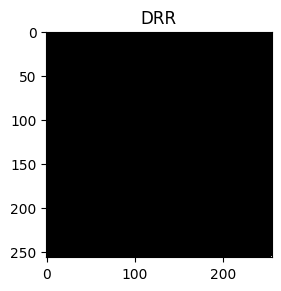

In [691]:

visualize(drr=patient_drr, pose= pred_pose_train, device=device)

In [335]:
def geodesic_distance(R1, R2):
    # cos_theta = (torch.trace(torch.matmul(R1.transpose(0, 1), R2)) - 1) / 2
    # return torch.acos(torch.clamp(cos_theta, -1, 1))

    r_oa_t = np.transpose(R1)

    r_ab = r_oa_t * R2
    
    res = (np.trace(r_ab) - 1) / 2
    return np.rad2deg(np.arccos((np.trace(r_ab) - 1) / 2))

pred_r_n = pred_r.detach().cpu().numpy().squeeze(0)


res = geodesic_distance(pred_r_n, gt_r)
res

NameError: name 'pred_r' is not defined

In [ ]:
def l2_norm(T1, T2):
    dist = np.linalg.norm(T1-T2)
    return dist
pred_t_n = pred_t.detach().cpu().numpy().squeeze(0)
l2_norm(gt_t, pred_t_n)

1086.56685592885